In [7]:
!pip install seaborn

     |████████████████████████████████| 292 kB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 25.2 MB/s eta 0:00:01
  Using cached pandas-1.3.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
     |████████████████████████████████| 1.1 MB 40.3 MB/s eta 0:00:01
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [8]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def plot_headmap_v2(data_list, index, columns_list, save_file=None, color="Blues"):
    fig, ax = plt.subplots(nrows=1, ncols=len(data_list), figsize=(3, 4))
#     fig = plt.figure(figsize=(3, 2), tight_layout=True, constrained_layout=True)
#     axes = []
#     for n, title in enumerate(titles):
#         axes.append(fig.add_subplot(1, len(titles), n+1, title=title, fontsize=25))
    fig.show()
    
    for n, (data, columns) in enumerate(zip(data_list, columns_list)):    
        df = pd.DataFrame(data=data, index=index, columns=columns)
#         ax.set_title(titles[n], fontsize=20)
        if n > 0:
            sns.heatmap(
                df, annot=True,  yticklabels=[], cmap=color, 
                ax=ax, cbar=None, vmax=1, vmin=0
            )
            continue
        sns.heatmap(df, annot=True, cmap=color, ax=ax, cbar=None, vmax=1, vmin=0)
        plt.tight_layout()
    if save_file:
        fig.savefig(save_file)

In [18]:
index = ['Emb'] + [f'L{n}' for n in range(1, 7, 1)]

In [24]:
to_en_column= ["Fr-En", "Ja-En"]
to_en_enc = [
    [0.76, 0.44],
    [0.80, 0.55],
    [0.79, 0.55],
    [0.78, 0.55],
    [0.80, 0.55],
    [0.80, 0.55],
    [0.79, 0.54]
]

to_en_dec = [
    [0.11, 0.09],
    [0.13, 0.07],
    [0.21, 0.11],
    [0.28, 0.18],
    [0.35, 0.13],
    [0.34, 0.08],
    [0.34, 0.34]
]

to_en_self_attn_dec = [
    [0.11, 0.09],
    [0.11, 0.09],
    [0.21, 0.15],
    [0.31, 0.22],
    [0.37, 0.23],
    [0.38, 0.20],
    [0.31, 0.10],
]

from_en_column = ["En-Fr", "En-Ja"]
from_en_enc = [
    [0.98, 0.99],
    [0.91, 0.96],
    [0.89, 0.93],
    [0.88, 0.93],
    [0.88, 0.92],
    [0.87, 0.92],
    [0.84, 0.93]
]

from_en_dec = [
    [0.11, 0.06],
    [0.13, 0.10],
    [0.19, 0.12],
    [0.26, 0.15],
    [0.29, 0.18],
    [0.29, 0.20],
    [0.27, 0.55]
]

from_en_self_attn_dec = [
    [0.11, 0.08],
    [0.10, 0.07],
    [0.19, 0.10],
    [0.28, 0.12],
    [0.32, 0.17],
    [0.33, 0.22],
    [0.27, 0.26],
]

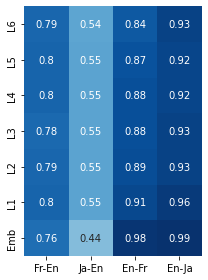

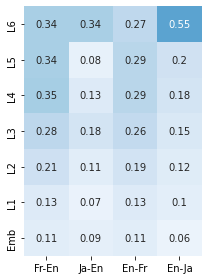

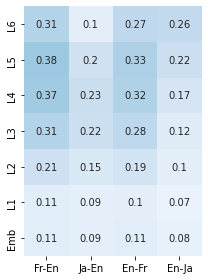

In [25]:
plot_headmap_v2(
    [np.concatenate([np.array(to_en_enc[::-1]), np.array(from_en_enc[::-1])], 1)], 
    index[::-1], [to_en_column+from_en_column],
#     titles=["Encoder", "Decoder", "Decoder (Self Attn)"],
    save_file="encoder_cka_en.png"
)
plot_headmap_v2(
    [np.concatenate([np.array(to_en_dec[::-1]), np.array(from_en_dec[::-1])], 1)], 
    index[::-1], [to_en_column+from_en_column],
#     titles=["Encoder", "Decoder", "Decoder (Self Attn)"],
    save_file="decoder_cka_en.png"
)
plot_headmap_v2(
    [np.concatenate([np.array(to_en_self_attn_dec[::-1]), np.array(from_en_self_attn_dec[::-1])], 1)], 
    index[::-1], [to_en_column+from_en_column],
#     titles=["Encoder", "Decoder", "Decoder (Self Attn)"],
    save_file="decoder_attn_cka_en.png"
)

In [15]:
to_ja_column= ["Ko-Ja", "En-Ja"]
to_ja_enc = [
    [0.88, 0.43],
    [0.90, 0.45],
    [0.89, 0.45],
    [0.88, 0.46],
    [0.89, 0.44],
    [0.91, 0.43],
    [0.89, 0.42]
]

to_ja_dec = [
    [0.15, 0.21],
    [0.23, 0.24],
    [0.28, 0.33],
    [0.30, 0.36],
    [0.34, 0.40],
    [0.30, 0.31],
    [0.12, 0.06]
]

to_ja_self_attn_dec = [
    [0.15, 0.21],
    [0.20, 0.27],
    [0.27, 0.31],
    [0.31, 0.37],
    [0.34, 0.39],
    [0.34, 0.37],
    [0.28, 0.26]
]

from_ja_column = ["Ja-Ko", "Ja-En"]
from_ja_enc = [
    [0.99, 0.99],
    [0.98, 0.97],
    [0.97, 0.95],
    [0.97, 0.92],
    [0.96, 0.91],
    [0.97, 0.92],
    [0.97, 0.94]
]

from_ja_dec = [
    [0.12, 0.11],
    [0.25, 0.20],
    [0.31, 0.29],
    [0.34, 0.36],
    [0.38, 0.44],
    [0.37, 0.33],
    [0.14, 0.15]
]

from_ja_self_attn_dec = [
    [0.12, 0.11],
    [0.18, 0.18],
    [0.31, 0.26],
    [0.35, 0.34],
    [0.38, 0.43],
    [0.39, 0.41],
    [0.32, 0.31]
]

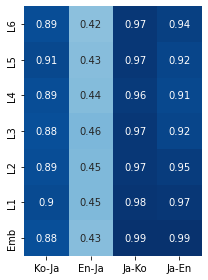

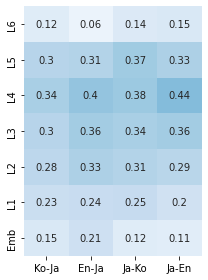

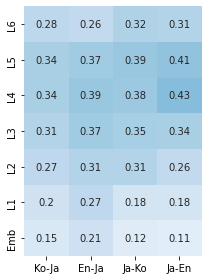

In [17]:
plot_headmap_v2(
    [np.concatenate([np.array(to_ja_enc[::-1]), np.array(from_ja_enc[::-1])], 1)], 
    index[::-1], [to_ja_column+from_ja_column],
#     titles=["Encoder", "Decoder", "Decoder (Self Attn)"],
    save_file="encoder_cka_ja_random.png"
)

plot_headmap_v2(
    [np.concatenate([np.array(to_ja_dec[::-1]), np.array(from_ja_dec[::-1])], 1)], 
    index[::-1], [to_ja_column+from_ja_column],
#     titles=["Encoder", "Decoder", "Decoder (Self Attn)"],
    save_file="decoder_cka_ja_random.png"
)

plot_headmap_v2(
    [np.concatenate([np.array(to_ja_self_attn_dec[::-1]), np.array(from_ja_self_attn_dec[::-1])], 1)], 
    index[::-1], [to_ja_column+from_ja_column],
#     titles=["Encoder", "Decoder", "Decoder (Self Attn)"],
    save_file="decoder_self_cka_ja_random.png"
)

In [ ]:
plot_headmap_v2(
    [np.concatenate([np.array(to_ja_enc[::-1]), np.array(from_ja_enc[::-1])], 1)], 
    index[::-1], [to_ja_column+from_ja_column],
#     titles=["Encoder", "Decoder", "Decoder (Self Attn)"],
    save_file="encoder_cka_ja_random.png"
)